In [1]:
import torch
import torch.nn as nn

class CompactCNN(nn.Module):
    def __init__(self):
        super(CompactCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=5, stride=4)
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=5, stride=4)
        self.fc = nn.Linear(in_features=4*12*112, out_features=2)

    def forward(self, x):
        # Checking the input dimensions
        assert x.size()[2:] == (201, 1800), "Input dimensions must be 1x201x1800"
        x = torch.tanh(self.conv1(x))
        x = torch.tanh(self.conv2(x))
        x = x.view(-1, 4*12*112)
        x = self.fc(x)
        return x


net = CompactCNN()


print(net)

total_params = sum(p.numel() for p in net.parameters())
print(f'Total number of parameters: {total_params}') 



CompactCNN(
  (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(4, 4))
  (conv2): Conv2d(2, 4, kernel_size=(5, 5), stride=(4, 4))
  (fc): Linear(in_features=5376, out_features=2, bias=True)
)
Total number of parameters: 11010


Training

In [2]:
# loss function: mean-squared error (MSE) on the predicted and ground-truth relative home vector
# a batch size: 1
# learning rate: 9e−4
# single epoch
# optimizer: Adam

# the dataset is grey-scale images of size 201x1800, stored in a folder called 'data_gym/training'.
# the labels are stored in a csv file called 'processed.csv' with the following format:
# "filename, id, gaze, pos_x, pos_y, label_1, label_2\n"
# both label 1 and label 2 are floats, representing the relative home position in the x and y directions, respectively.


# start loading the data and training the network

import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time

# define the dataset class
class GazeDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path).convert('L')  # Ensure the image is in 'L' mode (grayscale)
        numeric_data = self.annotations.iloc[index, 5:7].values.astype(float)  # Convert to float
        # numeric_data = self.annotations.iloc[index, 3:5].values.astype(float)  # train to output x,y instead of vector
        y_label = torch.tensor(numeric_data, dtype=torch.float)  # Explicitly specify the dtype as float

        if self.transform:
            image = self.transform(image)
            
        return (image, y_label)

    
# define the transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((201, 1800)),
    transforms.ToTensor()
])

# define the dataset
dataset = GazeDataset(
    csv_file="data_gym/processed.csv",
    root_dir="data_gym/training",
    transform=transform
)

# define the data loader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# define the loss function
loss_function = nn.MSELoss()

# define the optimizer
optimizer = optim.Adam(net.parameters(), lr=9e-4)

# define the training loop
def train(net, dataloader, loss_function, optimizer):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if i % 100 == 99:
            print(f'[{i+1}, {i+1}] loss: {running_loss/100}')

            # save the iteration idx and loss
            with open('loss_loc_notshuffled.txt', 'a') as f:
                f.write(f'{i+1},{running_loss/100}\n')

            running_loss = 0.0

# train the network
start_time = time.time()
train(net, dataloader, loss_function, optimizer)
end_time = time.time()
print(f'Training time: {end_time-start_time} seconds')

# save the model
# PATH = './gaze_net.pth'
# torch.save(net.state_dict(), PATH)


[100, 100] loss: 0.014581897233953072
[200, 200] loss: 0.00010033795653100696
[300, 300] loss: 7.795549960633252e-05
[400, 400] loss: 0.00026122947305793785
[500, 500] loss: 0.00012984702465132614
[600, 600] loss: 0.00013947563788121897
[700, 700] loss: 0.0001817928232412669
[800, 800] loss: 0.0005421230962161872
[900, 900] loss: 0.00012556448221403115
[1000, 1000] loss: 0.0002059955418963
[1100, 1100] loss: 0.001114453882455564
[1200, 1200] loss: 0.0001395319500147707
[1300, 1300] loss: 8.768481909456227e-05
[1400, 1400] loss: 0.000224179567394458
[1500, 1500] loss: 0.0012067999062924174
[1600, 1600] loss: 0.0001069388517180414
[1700, 1700] loss: 0.00012178454065860933
[1800, 1800] loss: 0.00011785918411135299
[1900, 1900] loss: 0.0002069724902884218
[2000, 2000] loss: 0.00013855794374308063
[2100, 2100] loss: 0.00014143941862812426
[2200, 2200] loss: 0.0011427783073179399
[2300, 2300] loss: 4.853359828075554e-05
[2400, 2400] loss: 0.00034032187707680353
[2500, 2500] loss: 0.000393384

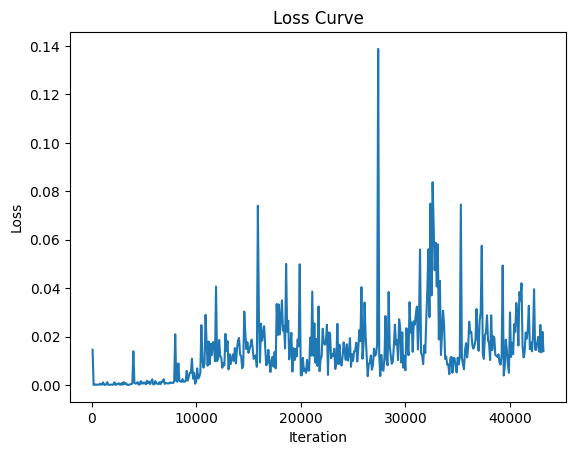

In [3]:
#  plot the loss curve
loss_data = np.loadtxt('loss_loc_notshuffled.txt', delimiter=',')
plt.plot(loss_data[:,0], loss_data[:,1])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.savefig('loss_curve.png')

Time needed for each image: 0.00096893310546875 seconds
Ground truth: [-0.66896474  0.74329412]
Prediction: [-0.3074607  -0.75343925]
Time needed for each image: 0.0017783641815185547 seconds
Ground truth: [-0.70710677  0.70710677]
Prediction: [-0.47138742 -0.79309535]
Time needed for each image: 0.001007080078125 seconds
Ground truth: [-0.70710677  0.70710677]
Prediction: [-0.45699006 -0.75825834]
Time needed for each image: 0.0009379386901855469 seconds
Ground truth: [-0.75257671  0.65850461]
Prediction: [-0.45174259 -0.73163873]
Time needed for each image: 0.0008137226104736328 seconds
Ground truth: [-0.70710677  0.70710677]
Prediction: [-0.369856   -0.69333255]
Time needed for each image: 0.0008480548858642578 seconds
Ground truth: [-0.81373346  0.58123821]
Prediction: [-0.26985115 -0.73040909]
Time needed for each image: 0.002602100372314453 seconds
Ground truth: [-0.76822126  0.6401844 ]
Prediction: [-0.33115876 -0.64655423]
Time needed for each image: 0.003780841827392578 second

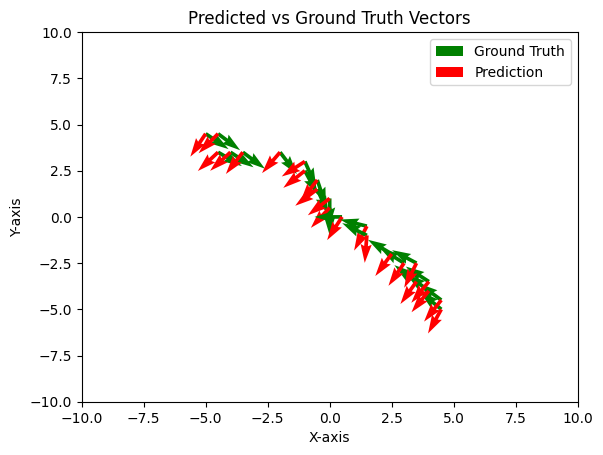

Test loss: 0.8622670329135397


In [6]:
# test the network
# test dataset is stored in a folder called 'data_gym/processed_testing'
# test labels are stored in a csv file called 'processed_testing.csv' with the following format:
# "filename, id, gaze, pos_x, pos_y, label_1, label_2\n"


"""import the model saved previously gaze_net.pth"""
# import the model saved previously gaze_net.pth
# PATH = './gaze_net.pth'
# net = CompactCNN()
# net.load_state_dict(torch.load(PATH))



# define the test dataset
test_dataset = GazeDataset(
    csv_file="data_gym/processed_testing_new.csv",
    root_dir="data_gym/processed_testing",
    transform=transform
)

# define the test data loader
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# define the test loop
def test(net, dataloader, loss_function):
    net.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels = data
            outputs = net(inputs)
            loss = loss_function(outputs, labels)
            running_loss += loss.item()
            
            
    print(f'Test loss: {running_loss/len(dataloader)}')

# plot the results


def plot_results(net, dataloader, csv_file):
    net.eval()
    fig, ax = plt.subplots()
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)

    annotations = pd.read_csv(csv_file)

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            # record how much time needed for each image
            start_time = time.time()

            inputs, labels = data
            outputs = net(inputs)

            # record how much time needed for each image
            end_time = time.time()
            print(f'Time needed for each image: {end_time-start_time} seconds')

            # Get the corresponding row from the CSV file
            row = annotations.iloc[i]
            pos_x, pos_y = row[' pos_x'], row[' pos_y']

            # Ground truth and prediction vectors
            gt_vector = labels.numpy()[0]
            pred_vector = outputs.numpy()[0]

            transformation_matrix = np.array([[0, 1], [-1, 0]])
            # transform both gt and pred vectors
            gt_vector = np.matmul(transformation_matrix, gt_vector)
            pred_vector = np.matmul(transformation_matrix, pred_vector)

            # print gt, pred and pos
            print(f'Ground truth: {gt_vector}')
            print(f'Prediction: {pred_vector}')
            # print(f'Position: ({pos_x}, {pos_y})')

            # Plotting
            ax.quiver(pos_x, pos_y, gt_vector[0], gt_vector[1], angles='xy', scale_units='xy', color='g')
            ax.quiver(pos_x, pos_y, pred_vector[0], pred_vector[1], angles='xy', scale_units='xy', color='r')


            """For relocalization only from here onwards"""
            # Plotting
            # from i=7 on, plot the ground truth using dots and connect them with lines
            # also plot the predicted points and connect them with lines
            # if i>=1 and i<7:
            #     prev_pos_x, prev_pos_y = annotations.iloc[i-1][' pos_x'], annotations.iloc[i-1][' pos_y']
            #     # ax.scatter(pos_x, pos_y, color='g')
            #     # plot the predicted
            #     # ax.scatter(prev_pred_x, prev_pred_y, color='r')
               
            #     ax.plot([prev_pos_x, pos_x], [prev_pos_y, pos_y], color='g')
            #     ax.plot([prev_pred_x, pred_vector[0]], [prev_pred_y, pred_vector[1]], color='r')

            """only plot the dataset from point 7 on"""
            # if i >= 7:
            #     # plot the ground truth
            #     prev_pos_x, prev_pos_y = annotations.iloc[i-1][' pos_x'], annotations.iloc[i-1][' pos_y']
            #     # ax.scatter(pos_x, pos_y, color='g')
            #     # plot the predicted
            #     # ax.scatter(prev_pred_x, prev_pred_y, color='r')
            #     if i >= 8:
            #         ax.plot([prev_pos_x, pos_x], [prev_pos_y, pos_y], color='g')
            #         ax.plot([prev_pred_x, pred_vector[0]], [prev_pred_y, pred_vector[1]], color='r')

            # prev_pred_x, prev_pred_y = pred_vector[0], pred_vector[1]


    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Predicted vs Ground Truth Vectors')
    plt.legend(['Ground Truth', 'Prediction'])
    plt.show()


plot_results(net, test_dataloader, "data_gym/processed_testing_new.csv")

            

# test the network
test(net, test_dataloader, loss_function)



